In [84]:
%load_ext autoreload
%autoreload 2
import warnings 
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import pandas as pd 

file_path = '/Users/ddelgado/Tippers/tipDataSet/tip.csv'
# Extract the CSV file from the zip archive

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


In [86]:
df


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [87]:
from sklearn.preprocessing import LabelEncoder
import torch

le = LabelEncoder()
def prepare_data(df):
  #removing columns that are not needed
  # df.drop('smoker', axis=1, inplace=True)
  day_mapping = {'Sun': 1, 'Sat': 1, 'Fri': 1, 'Thur':0}
  # Create a new column 'day_encoded' based on Weekday or Weekend
  df['day_encoded'] = df['day'].map(day_mapping)
  # Create a new column "time_encoded" based on Lunch or Dinner
  df['time_encoded'] = le.fit_transform(df['time'])
  # Creates a new column 'smoker_encoded' based on Yes or No
  df['smoker_encoded'] = le.fit_transform(df['smoker'])
  # Creates a new column "sex_encoded'" based on female or male
  df['sex_encoded'] = le.fit_transform(df['sex'])
  # Creates a new column 'percent_tip' based on the percentage of the tip amount
  df['percent_tip'] = (df['tip'] / df['total_bill']) * 100
  # Round the 'percent_tip' column to two decimal places
  df['percent_tip'] = df['percent_tip'].round()
  #makes groups for tips to 25+
  tip_groups = [0, 10, 15, 20, 25, float('inf')]
  label_tip_groups = ['0-10%', '10-15%', '15-20%', '20-25%', '25+']
  df['tip_groups'] = pd.cut(df['percent_tip'], bins = tip_groups, labels= label_tip_groups)
  df['tip_groups'] = df['tip_groups'].astype(str)
  df['tip_groups'] = df['tip_groups'].str.extract(r'(\d+)').astype(float)

  le.fit(df["tip_groups"])
  #turns the labels in 'tip' to a number
  y = le.transform(df["tip_groups"])
  print(y)
  #removing 'tip' col bc now held by y
  df = df.drop(["tip_groups"], axis = 1)

#drop tip, and percent_tip?

  #converted into “one-hot encoded” 0-1 columns
  df = pd.get_dummies(df)
  return df, y
X_train, y_train = prepare_data(df)

[0 2 2 1 1 2 3 1 1 3 2 1 0 2 2 2 2 3 3 2 3 1 1 2 2 1 1 2 2 1 1 1 2 1 2 1 1
 2 1 2 1 1 3 1 2 2 3 2 0 2 2 3 1 2 2 2 0 0 2 1 2 1 2 3 1 2 1 4 0 1 2 2 1 2
 1 1 2 1 1 2 1 2 2 1 1 1 1 3 3 1 0 2 2 4 1 1 1 1 1 1 3 2 0 2 2 1 2 2 3 4 3
 1 1 1 2 2 2 1 1 1 2 1 2 1 2 1 2 1 2 0 0 1 1 2 2 1 2 1 1 3 2 2 1 2 1 2 0 1
 2 4 2 1 2 0 0 2 0 1 2 1 2 2 1 1 2 1 1 1 1 2 2 2 4 0 3 0 1 1 4 0 1 3 0 4 0
 3 2 0 2 2 0 3 0 1 3 2 2 1 1 1 3 2 1 1 2 2 1 0 0 2 0 2 2 2 3 0 1 1 2 0 2 4
 3 2 1 1 2 1 2 1 0 2 4 1 2 1 0 0 1 2 0 0 0 2]


In [88]:
X_train.shape

(244, 18)

In [89]:
df

,total_bill,tip,sex,smoker,day,time,size,day_encoded,time_encoded,smoker_encoded,sex_encoded,percent_tip,tip_groups
0,16.99,1.01,Female,No,Sun,Dinner,2,1,0,0,0,6.0,0.0
1,10.34,1.66,Male,No,Sun,Dinner,3,1,0,0,1,16.0,15.0
2,21.01,3.50,Male,No,Sun,Dinner,3,1,0,0,1,17.0,15.0
3,23.68,3.31,Male,No,Sun,Dinner,2,1,0,0,1,14.0,10.0
4,24.59,3.61,Female,No,Sun,Dinner,4,1,0,0,0,15.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1,0,0,1,20.0,15.0
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1,0,1,0,7.0,0.0
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1,0,1,1,9.0,0.0
242,17.82,1.75,Male,No,Sat,Dinner,2,1,0,0,1,10.0,0.0


In [90]:
X_train

,total_bill,tip,size,day_encoded,time_encoded,smoker_encoded,sex_encoded,percent_tip,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2,1,0,0,0,6.0,True,False,True,False,False,False,True,False,True,False
1,10.34,1.66,3,1,0,0,1,16.0,False,True,True,False,False,False,True,False,True,False
2,21.01,3.50,3,1,0,0,1,17.0,False,True,True,False,False,False,True,False,True,False
3,23.68,3.31,2,1,0,0,1,14.0,False,True,True,False,False,False,True,False,True,False
4,24.59,3.61,4,1,0,0,0,15.0,True,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,3,1,0,0,1,20.0,False,True,True,False,False,True,False,False,True,False
240,27.18,2.00,2,1,0,1,0,7.0,True,False,False,True,False,True,False,False,True,False
241,22.67,2.00,2,1,0,1,1,9.0,False,True,False,True,False,True,False,False,True,False
242,17.82,1.75,2,1,0,0,1,10.0,False,True,True,False,False,True,False,False,True,False


## Visualizations

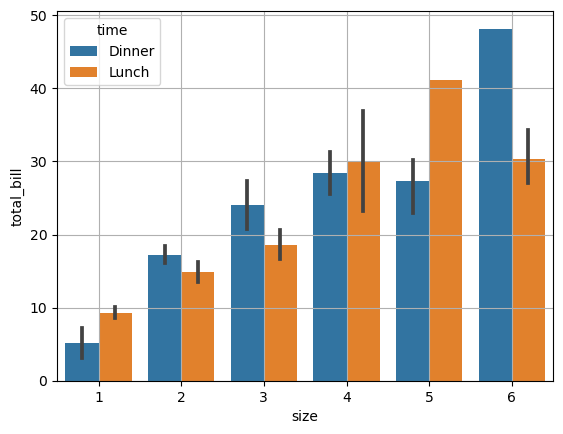

In [91]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.barplot(data = df, x = "size", y = "total_bill", hue = "time")

plt.title('')
plt.grid(True)
plt.show()

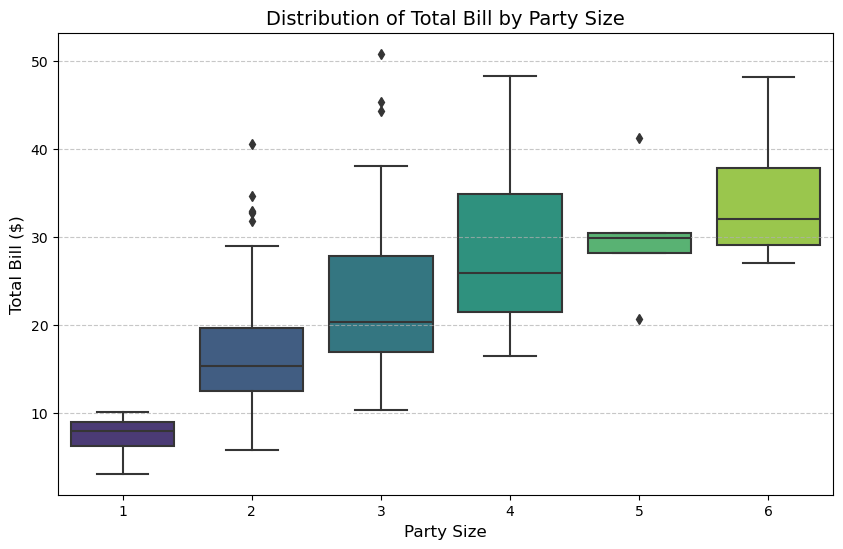

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='size', y='total_bill', data=df, palette='viridis')
plt.title('Distribution of Total Bill by Party Size', fontsize=14)
plt.xlabel('Party Size', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



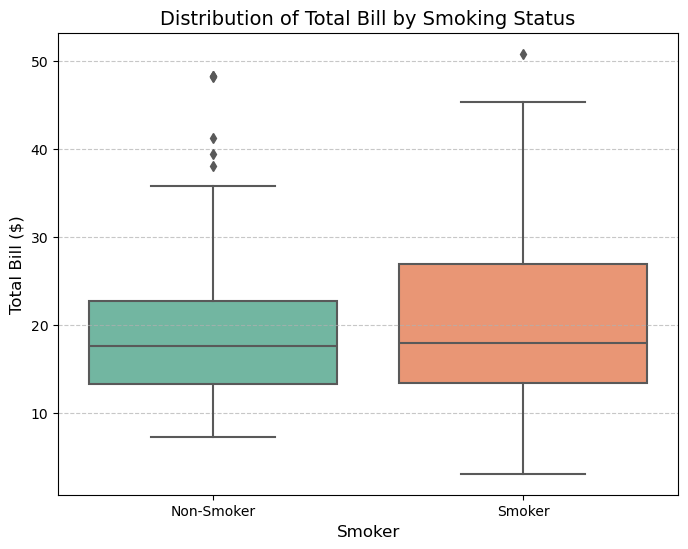

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='total_bill', data=df, palette='Set2')
plt.title('Distribution of Total Bill by Smoking Status', fontsize=14)
plt.xlabel('Smoker', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'], fontsize=10)  # Customize x-axis labels
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


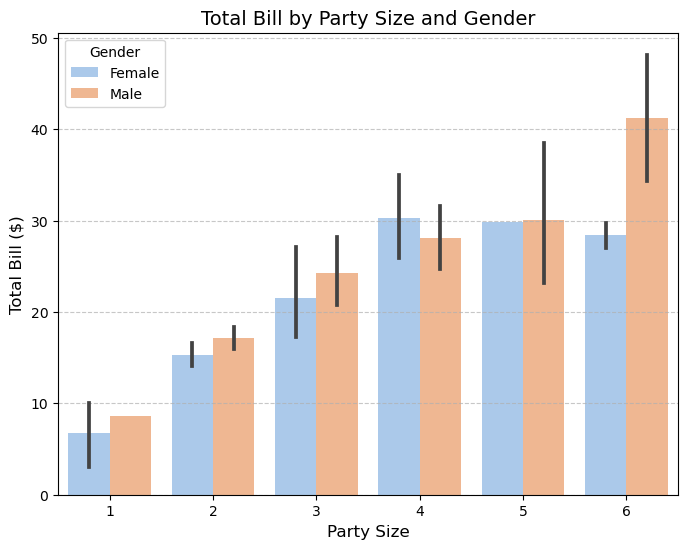

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='size', y='total_bill', hue='sex', data=df, palette='pastel')
plt.title('Total Bill by Party Size and Gender', fontsize=14)
plt.xlabel('Party Size', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Gender', fontsize=10, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [95]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2)

In [96]:
predictor_cols = ["size", "day_encoded", "time_encoded", "total_bill", "smoker_encoded",'sex_encoded']
target_col = ["tip_groups"]

X_train = df_train[predictor_cols]
y_train = df_train[target_col]

X_test = df_test[predictor_cols]
y_test = df_test[target_col]

In [97]:
print(df_train.shape)
print(df_test.shape)

(195, 13)
(49, 13)


# Basic Logistic Regression Score

### Basic Logistic Regression Score on Training Data

In [98]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

result = LR.fit(X_train, y_train)
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.4512820512820513

### Basic Logistic Regression Score on Testing Data

In [99]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.32653061224489793

### Combination Logistic Regression Score on Training Data

In [100]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
import random

# issue is we are looking at same cateogories --> looking at sexes in both quan and qual cols
all_qual_cols= ["sex", "smoker","day", "time"]
all_quan_cols = ["total_bill", "size"]

score_counter = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_train.columns if qual in col ]
  for quan in range(1, len(all_quan_cols) + 1):
    for comb in combinations(all_quan_cols, quan):
      cols = list(comb) + qual_cols
      print(cols)
      # training LR model and scoring it
      LR = LogisticRegression()
      #using cross validation on LR to avoid overfitting
      cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5) #training on remaining 80% of data

      if cv_scores_LR.mean() > score_counter:
        #updating the best score and columns of that score
        score_counter = cv_scores_LR.mean()
        col_best = cols

print('Best Score: ', score_counter)
print('Best Columns: ', col_best)

['total_bill', 'sex_encoded']
['size', 'sex_encoded']
['total_bill', 'size', 'sex_encoded']
['total_bill', 'smoker_encoded']
['size', 'smoker_encoded']
['total_bill', 'size', 'smoker_encoded']
['total_bill', 'day_encoded']
['size', 'day_encoded']
['total_bill', 'size', 'day_encoded']
['total_bill', 'time_encoded']
['size', 'time_encoded']
['total_bill', 'size', 'time_encoded']
Best Score:  0.4000000000000001
Best Columns:  ['total_bill', 'size', 'time_encoded']


In [101]:
cols = col_best

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.4564102564102564

### Combination Logistic Regression Score on Testing Data

In [102]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

all_qual_cols= ["sex", "smoker","day", "time"]
all_quan_cols = ["total_bill", "size"]

score_counter = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_train.columns if qual in col ]
  for quan in range(1, len(all_quan_cols) + 1):
    for comb in combinations(all_quan_cols, quan):
      cols = list(comb) + qual_cols
      print(cols)
    # training LR model and scoring it
    LR = LogisticRegression()
    #using cross validation on LR to avoid overfitting
    cv_scores_LR = cross_val_score(LR, X_test[cols], y_test, cv = 5) #training on remaining 80% of data

    if cv_scores_LR.mean() > score_counter:
      #updating the best score and columns of that score
      score_counter = cv_scores_LR.mean()
      col_best = cols

print('Best Score: ', score_counter)
print('Best Three Columns: ', col_best)

['total_bill', 'sex_encoded']
['size', 'sex_encoded']
['total_bill', 'size', 'sex_encoded']
['total_bill', 'smoker_encoded']
['size', 'smoker_encoded']
['total_bill', 'size', 'smoker_encoded']
['total_bill', 'day_encoded']
['size', 'day_encoded']
['total_bill', 'size', 'day_encoded']
['total_bill', 'time_encoded']
['size', 'time_encoded']
['total_bill', 'size', 'time_encoded']
Best Score:  0.4733333333333333
Best Three Columns:  ['size', 'smoker_encoded']


In [103]:
cols = col_best

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_test[cols], y_test)

0.22448979591836735

# Logistic Regression with Optimization Score

In [21]:
from sklearn.model_selection import cross_val_score
from GDO import LogisticRegression, GradientDescentOptimizer
import torch

In [22]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.double)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.double)

In [23]:
LRO = LogisticRegression()
opt = GradientDescentOptimizer(LRO)

In [24]:


loss_vec = []

for _ in range(1):
    loss_var = LRO.loss(X_train_tensor,y_train_tensor)    
    loss_vec.append(loss_var)
    opt.step(X_train_tensor, y_train_tensor, alpha = 0.1, beta = 0.9) #optimizer with momentum


self.w inside of if statnemt tensor([0.9794, 0.9434, 0.9705, 0.6971, 0.0150, 0.7208], dtype=torch.float64)
s:  tensor([18.4002, 39.2296, 10.2992, 15.9717, 18.7606, 10.6426, 14.6587, 17.0458,
        21.3119,  8.8852, 10.9493, 16.9022, 20.3179, 10.3532, 19.1190, 28.1671,
        13.0849, 17.2162, 11.7989, 12.9429, 18.4654, 18.5455, 20.5560, 33.5983,
        17.2090, 21.7481, 28.8578, 15.1072, 15.2290, 15.7807, 18.9970, 15.6579,
        23.6441, 22.6541, 26.3999, 24.5694, 17.7816, 16.1296, 29.1262, 13.5904,
        17.7248, 33.0605, 27.6198, 10.8290, 26.1989, 21.6947, 40.0357, 26.5229,
        29.4399, 12.7756, 13.2646, 13.9258, 16.1086,  9.7364, 13.4001, 16.0170,
        13.2398, 21.2112, 18.3463, 16.3725, 21.3741, 23.5331, 16.5485,  9.0334,
        24.8385, 20.5392, 17.4390,  4.0778, 10.1301, 12.0062, 20.5368, 15.7939,
        35.3009, 21.6737, 14.2934, 12.2840, 12.4480, 19.2835, 16.9503, 23.3991,
        13.3821, 11.5939, 20.1297, 12.2360, 23.2109, 34.9539, 12.1673, 41.1188,
        1

### Plotting data and checking the prediction at 10,000 iterations

In [21]:
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
plt.grid(True)
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

NameError: name 'loss_vec' is not defined

In this graph, we can see that as we increase the number of gradient descent optimizer iterations, the graph flattens out to reach convergence.

In [24]:
from GDO import LogisticRegression

LRO = LogisticRegression()

GDO_predict = (1.0 * (LRO.predict(X_train_tensor) == y_train_tensor)).mean()
print("Prediction Accuracy with Gradient Descent Optimizer Training Data: ", float(GDO_predict))

X:  tensor([[ 2.0000,  1.0000,  0.0000, 17.3100,  0.0000,  0.0000],
        [ 4.0000,  1.0000,  0.0000, 21.5000,  0.0000,  1.0000],
        [ 2.0000,  1.0000,  1.0000, 13.4200,  1.0000,  1.0000],
        ...,
        [ 2.0000,  0.0000,  1.0000, 16.4300,  0.0000,  0.0000],
        [ 4.0000,  1.0000,  0.0000, 16.4900,  0.0000,  1.0000],
        [ 2.0000,  1.0000,  0.0000, 12.4600,  0.0000,  1.0000]],
       dtype=torch.float64)
self.w score tensor([0.8383, 0.5170, 0.4535, 0.5425, 0.1639, 0.7554])


### Running Gradient Descent on Testing Data

In [ ]:
from GDO import LogisticRegression

LRO = LogisticRegression()

X_test_tensor = torch.tensor(X_test.values, dtype=torch.double)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.double)


GDO_predict = (1.0 * (LRO.predict(X_test_tensor) == y_test_tensor)).mean()
print("Prediction Accuracy with Gradient Descent Optimizer Testing Data: ", float(GDO_predict))

X:  tensor([[ 2.0000,  1.0000,  0.0000, 20.2900,  0.0000,  0.0000],
        [ 2.0000,  1.0000,  0.0000, 20.9200,  0.0000,  0.0000],
        [ 4.0000,  1.0000,  0.0000, 30.4000,  0.0000,  1.0000],
        [ 4.0000,  1.0000,  0.0000, 18.3500,  0.0000,  1.0000],
        [ 4.0000,  1.0000,  0.0000, 25.5600,  0.0000,  1.0000],
        [ 2.0000,  0.0000,  1.0000, 13.0300,  0.0000,  1.0000],
        [ 3.0000,  1.0000,  0.0000, 20.6500,  0.0000,  1.0000],
        [ 2.0000,  0.0000,  1.0000, 14.5200,  0.0000,  0.0000],
        [ 3.0000,  1.0000,  0.0000, 16.9700,  0.0000,  0.0000],
        [ 2.0000,  1.0000,  0.0000, 12.9000,  1.0000,  0.0000],
        [ 1.0000,  1.0000,  0.0000,  7.2500,  0.0000,  0.0000],
        [ 2.0000,  1.0000,  0.0000,  9.6800,  0.0000,  1.0000],
        [ 4.0000,  1.0000,  0.0000, 23.1700,  1.0000,  1.0000],
        [ 2.0000,  1.0000,  0.0000, 14.8300,  0.0000,  0.0000],
        [ 2.0000,  0.0000,  1.0000, 13.4200,  0.0000,  0.0000],
        [ 2.0000,  0.0000,  1.0000, 

RuntimeError: expected scalar type Double but found Float

# Decision Tree Classifier Model Prediction Score

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


score_counter = 0
best_depth = 0

for i in range(1, 50):
    DTC = DecisionTreeClassifier(max_depth= i)
    cv_scores= cross_val_score(DTC, X_train, y_train, cv= 5)
    if(cv_scores.mean() > score_counter):
        score_counter = cv_scores.mean()
        best_depth = i


print("Best score: " , score_counter)
print("Best depth: " , best_depth)



Best score:  0.4564102564102564
Best depth:  5


In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


score_counter = 0
best_depth = 0

for i in range(1, 50):
    DTC = DecisionTreeClassifier(max_depth= i)
    cv_scores= cross_val_score(DTC, X_test, y_test, cv= 5)
    if(cv_scores.mean() > score_counter):
        score_counter = cv_scores.mean()
        best_depth = i


print("Best score: " , score_counter)
print("Best depth: " , best_depth)

Best score:  0.38666666666666666
Best depth:  39


### Combination Decision Tree Classifier on Training Data

In [146]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

all_qual_cols= ["sex", "smoker","day", "time"]
all_quan_cols = ["total_bill", "size", ]

score_counter = 0
best_depth = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_train.columns if qual in col ]
  for quan in range(1, len(all_quan_cols) + 1):
    for comb in combinations(all_quan_cols, quan):
      cols = list(comb) + qual_cols
      print(cols)
      # training DTC model and scoring it
      for i in range(1,10):
        #setting the max depth to be between 1-19 and iterating through each one
        DTC = DecisionTreeClassifier(max_depth=i)
        #using cross validation on DTC to avoid overfitting
        cv_scores_DTC = cross_val_score(DTC, X_train[cols], y_train, cv = 5)
        #updating the best score and columns of that score
        if cv_scores_DTC.mean() > score_counter:
          score_counter = cv_scores_DTC.mean()
          col_best = cols
          best_depth = i
    
print('Best Score: ', score_counter)
print('Best Three Columns: ', col_best)
print('At depth: ', best_depth)

['total_bill', 'sex_encoded']
['size', 'sex_encoded']
['total_bill', 'size', 'sex_encoded']
['total_bill', 'smoker_encoded']
['size', 'smoker_encoded']
['total_bill', 'size', 'smoker_encoded']
['total_bill', 'day_encoded']
['size', 'day_encoded']
['total_bill', 'size', 'day_encoded']
['total_bill', 'time_encoded']
['size', 'time_encoded']
['total_bill', 'size', 'time_encoded']
Best Score:  0.4769230769230769
Best Three Columns:  ['total_bill', 'smoker_encoded']
At depth:  5


In [147]:
cols = col_best

DTC = DecisionTreeClassifier(max_depth=i)
DTC.fit(X_train[cols], y_train)
DTC.score(X_train[cols], y_train)

0.8256410256410256

### Combination Decision Tree Classifier on Test Data

In [149]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

all_qual_cols= ["sex", "smoker","day", "time"]
all_quan_cols = ["total_bill", "size", ]

score_counter = 0
best_depth = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_train.columns if qual in col ]
  for quan in range(1, len(all_quan_cols) + 1):
    for comb in combinations(all_quan_cols, quan):
      cols = list(comb) + qual_cols
      print(cols)
      # training DTC model and scoring it
      for i in range(1,10):
        #setting the max depth to be between 1-19 and iterating through each one
        DTC = DecisionTreeClassifier(max_depth=i)
        #using cross validation on DTC to avoid overfitting
        cv_scores_DTC = cross_val_score(DTC, X_train[cols], y_train, cv = 5)
        #updating the best score and columns of that score
        if cv_scores_DTC.mean() > score_counter:
          score_counter = cv_scores_DTC.mean()
          col_best = cols
          best_depth = i
    
print('Best Score: ', score_counter)
print('Best Three Columns: ', col_best)
print('At depth: ', best_depth)

['total_bill', 'sex_encoded']
['size', 'sex_encoded']
['total_bill', 'size', 'sex_encoded']
['total_bill', 'smoker_encoded']
['size', 'smoker_encoded']
['total_bill', 'size', 'smoker_encoded']
['total_bill', 'day_encoded']
['size', 'day_encoded']
['total_bill', 'size', 'day_encoded']
['total_bill', 'time_encoded']
['size', 'time_encoded']
['total_bill', 'size', 'time_encoded']
Best Score:  0.4769230769230769
Best Three Columns:  ['total_bill', 'smoker_encoded']
At depth:  5


In [150]:
cols = col_best

DTC = DecisionTreeClassifier(max_depth=i)
DTC.fit(X_train[cols], y_train)
DTC.score(X_test[cols], y_test)

# THE CUT IS A SIGN OF OVERFITTING

0.3673469387755102

# Random Forest Classifier Prediction Score
### Basic Random Forest Classifier


In [151]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=100)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

In [152]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2857142857142857


### Combinations Ranodm Forest Classifier on Training Data

In [153]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

all_qual_cols= ["sex", "smoker","day", "time"]
all_quan_cols = ["total_bill", "size", ]

score_counter = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_train.columns if qual in col ]
  for quan in range(1, len(all_quan_cols) + 1):
    for comb in combinations(all_quan_cols, quan):
      cols = list(comb) + qual_cols
      print(cols)
      # training RFC model and scoring it
      for depth in range(1, 10):
        RFC = RandomForestClassifier(n_estimators=10, max_depth=depth)
        cv_scores_RFC = cross_val_score(RFC, X_train[cols], y_train, cv=5)
        mean_score = cv_scores_RFC.mean()
        # using cross validation on RFC to avoid overfitting 

      if cv_scores_RFC.mean() > score_counter:
        #updating the best score and columns of that score
        score_counter = cv_scores_RFC.mean()
        col_best = cols

print('Best Score: ', score_counter)
print('Best Columns: ', col_best)

['total_bill', 'sex_encoded']
['size', 'sex_encoded']
['total_bill', 'size', 'sex_encoded']
['total_bill', 'smoker_encoded']
['size', 'smoker_encoded']
['total_bill', 'size', 'smoker_encoded']
['total_bill', 'day_encoded']
['size', 'day_encoded']
['total_bill', 'size', 'day_encoded']
['total_bill', 'time_encoded']
['size', 'time_encoded']
['total_bill', 'size', 'time_encoded']
Best Score:  0.42051282051282046
Best Columns:  ['total_bill', 'smoker_encoded']


In [154]:
cols = col_best
RFC = RandomForestClassifier(n_estimators=10, max_depth=depth)
RFC.fit(X_train[cols], y_train)
y_pred = RFC.predict(X_train[cols])

print("Accuracy:", metrics.accuracy_score(y_train, y_pred))

Accuracy: 0.8358974358974359


### Combinations Random Forest Classifier on Testing Data

In [155]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

all_qual_cols= ["sex", "smoker","day", "time"]
all_quan_cols = ["total_bill", "size", ]

score_counter = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_test.columns if qual in col ]
  for quan in range(1, len(all_quan_cols) + 1):
    for comb in combinations(all_quan_cols, quan):
      cols = list(comb) + qual_cols
      print(cols)
      # training RFC model and scoring it
      for depth in range(1, 10):
        RFC = RandomForestClassifier(n_estimators=10, max_depth=depth)
        cv_scores_RFC = cross_val_score(RFC, X_test[cols], y_test, cv=5)
        mean_score = cv_scores_RFC.mean()
        # using cross validation on RFC to avoid overfitting 

      if cv_scores_RFC.mean() > score_counter:
        #updating the best score and columns of that score
        score_counter = cv_scores_RFC.mean()
        col_best = cols

print('Best Score: ', score_counter)
print('Best Columns: ', col_best)

['total_bill', 'sex_encoded']
['size', 'sex_encoded']
['total_bill', 'size', 'sex_encoded']
['total_bill', 'smoker_encoded']
['size', 'smoker_encoded']
['total_bill', 'size', 'smoker_encoded']
['total_bill', 'day_encoded']
['size', 'day_encoded']
['total_bill', 'size', 'day_encoded']
['total_bill', 'time_encoded']
['size', 'time_encoded']
['total_bill', 'size', 'time_encoded']
Best Score:  0.3888888888888889
Best Columns:  ['size', 'time_encoded']


In [156]:
cols = col_best
RFC = RandomForestClassifier(n_estimators=10, max_depth=depth)
RFC.fit(X_train[cols], y_train)
y_pred = RFC.predict(X_test[cols])

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4489795918367347


\begin{aligned}
    \mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1})
\end{aligned}
\tag{1}

### Backround Notes 

- The bigger the bill, the bigger the tip (measured in percentage of bill, not by quantity) (Lynn et al., 2012).
- In resturants, tipping does incentivize better service (Azar, 2009; Lynn & McCall, 2000)
- Would be very interesting if race was included in this data set
    - white servers get tipped more than black servers ((Lynn, Sturman, Ganley, Adams, Douglas & McNeil, 2008))
- Also would be interesting to include age of tipper, seeing as older populations tip based on service whole younger generations tip back on precedent (Lynn and Katz)
- Tipping behavoirs are stronger on the weekends(Conlin, Lynn & O’Donoghue, 2003)
- Higher tips for waitresses compared to waiters (Lynn & Simons, 2000)
    - (CAN WE SHOW THIS WITHIN OUR DATA?)
- Michael Lynn, Patrick Jabbour, Woo Gon Kim,Who uses tips as a reward for service and when? An examination of potential moderators of the service–tipping relationship,Journal of Economic Psychology,Volume 33, Issue 1 2012,Pages 90-103,ISSN 0167-4870,https://doi.org/10.1016/j.joep.2011.09.009.(https://www.sciencedirect.com/science/article/pii/S0167487011001474)

### To-Dos
- Ask Phil about DTC on why we get really high scores on testing set
    - lecture note 14 on own LR experiemnting with optimization--> implement torch
- we have a sign of overfitting whe it goes from 0.4 to 0.24
- Fix bug on our implementation of linear regression
- Add comments and write ups to the code, maybe a abstract, backround or conclusion section? 